## Libraries

In [39]:
import sys, os
sys.path.append('../utils')

from imp import reload
import preprocessing; reload(preprocessing)

from preprocessing import ImageProcessor, DatasetProcessor
from preprocessing import Analytics

import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
from PIL import Image

try:
    from sklearn.cross_validation import train_test_split
except ImportError:
    from sklearn.model_selection import train_test_split  


import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline

## Split dataset

In [2]:
#DatasetProcessor.file_train_test_split()

## Const params

In [3]:
image_size = 128
SEED = 42
TRAIN_PATH = '../input/train/'
VALIDATE_PATH = '../input/validation/'

random.seed(SEED)
tf.set_random_seed(SEED)

## Load the data

In [4]:
wnids_train = DatasetProcessor.get_dataset_wnids(dataset_dir=TRAIN_PATH)
wnids_test = DatasetProcessor.get_dataset_wnids(dataset_dir=VALIDATE_PATH)

In [5]:
wnid_to_lable = DatasetProcessor.get_wnid_table()

train = DatasetProcessor.get_dataset_paths_from_wnid(wnids_train, dataset_path=TRAIN_PATH)
test = DatasetProcessor.get_dataset_paths_from_wnid(wnids_test, dataset_path=VALIDATE_PATH)

## Transform data and create consts

In [6]:
wnid_to_one_hot = DatasetProcessor.wnid_to_one_hot(wnids_train)
lables = sorted(wnid_to_one_hot.keys())

In [7]:
y_train = DatasetProcessor.paths_to_one_hot(train, wnid_to_one_hot)
y_test = DatasetProcessor.paths_to_one_hot(test, wnid_to_one_hot)

In [8]:
TRAIN_SIZE = len(train)
TEST_SIZE = len(test)

## Exploritory analysis

In [9]:
print ('Train size:', len(train))
print ('Test size:', len(test))
print ('Class number:', len(wnids_train))

Train size: 14929
Test size: 1649
Class number: 15


In [10]:
wnids_train = sorted(wnids_train)
print(wnids_train)

['n01493146', 'n01495006', 'n01859496', 'n01860002', 'n01860187', 'n02058594', 'n02058747', 'n02114712', 'n02119477', 'n02133704', 'n02134084', 'n02165877', 'n02166229', 'n02166567', 'n02166826']


In [11]:
classes = [wnid_to_lable[wnid] for wnid in wnids_train]
print ('Lables:', classes)

Lables: ['whitetip shark, reef whitetip shark, Triaenodon obseus', 'shovelhead, bonnethead, bonnet shark, Sphyrna tiburo', 'tundra swan, Cygnus columbianus', 'trumpeter, trumpeter swan, Cygnus buccinator', 'black swan, Cygnus atratus', 'wandering albatross, Diomedea exulans', 'black-footed albatross, gooney, gooney bird, goonie, goony, Diomedea nigripes', 'red wolf, maned wolf, Canis rufus, Canis niger', 'red fox, Vulpes fulva', 'Asiatic black bear, black bear, Ursus thibetanus, Selenarctos thibetanus', 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'two-spotted ladybug, Adalia bipunctata', 'Mexican bean beetle, bean beetle, Epilachna varivestis', 'Hippodamia convergens', 'vedalia, Rodolia cardinalis']


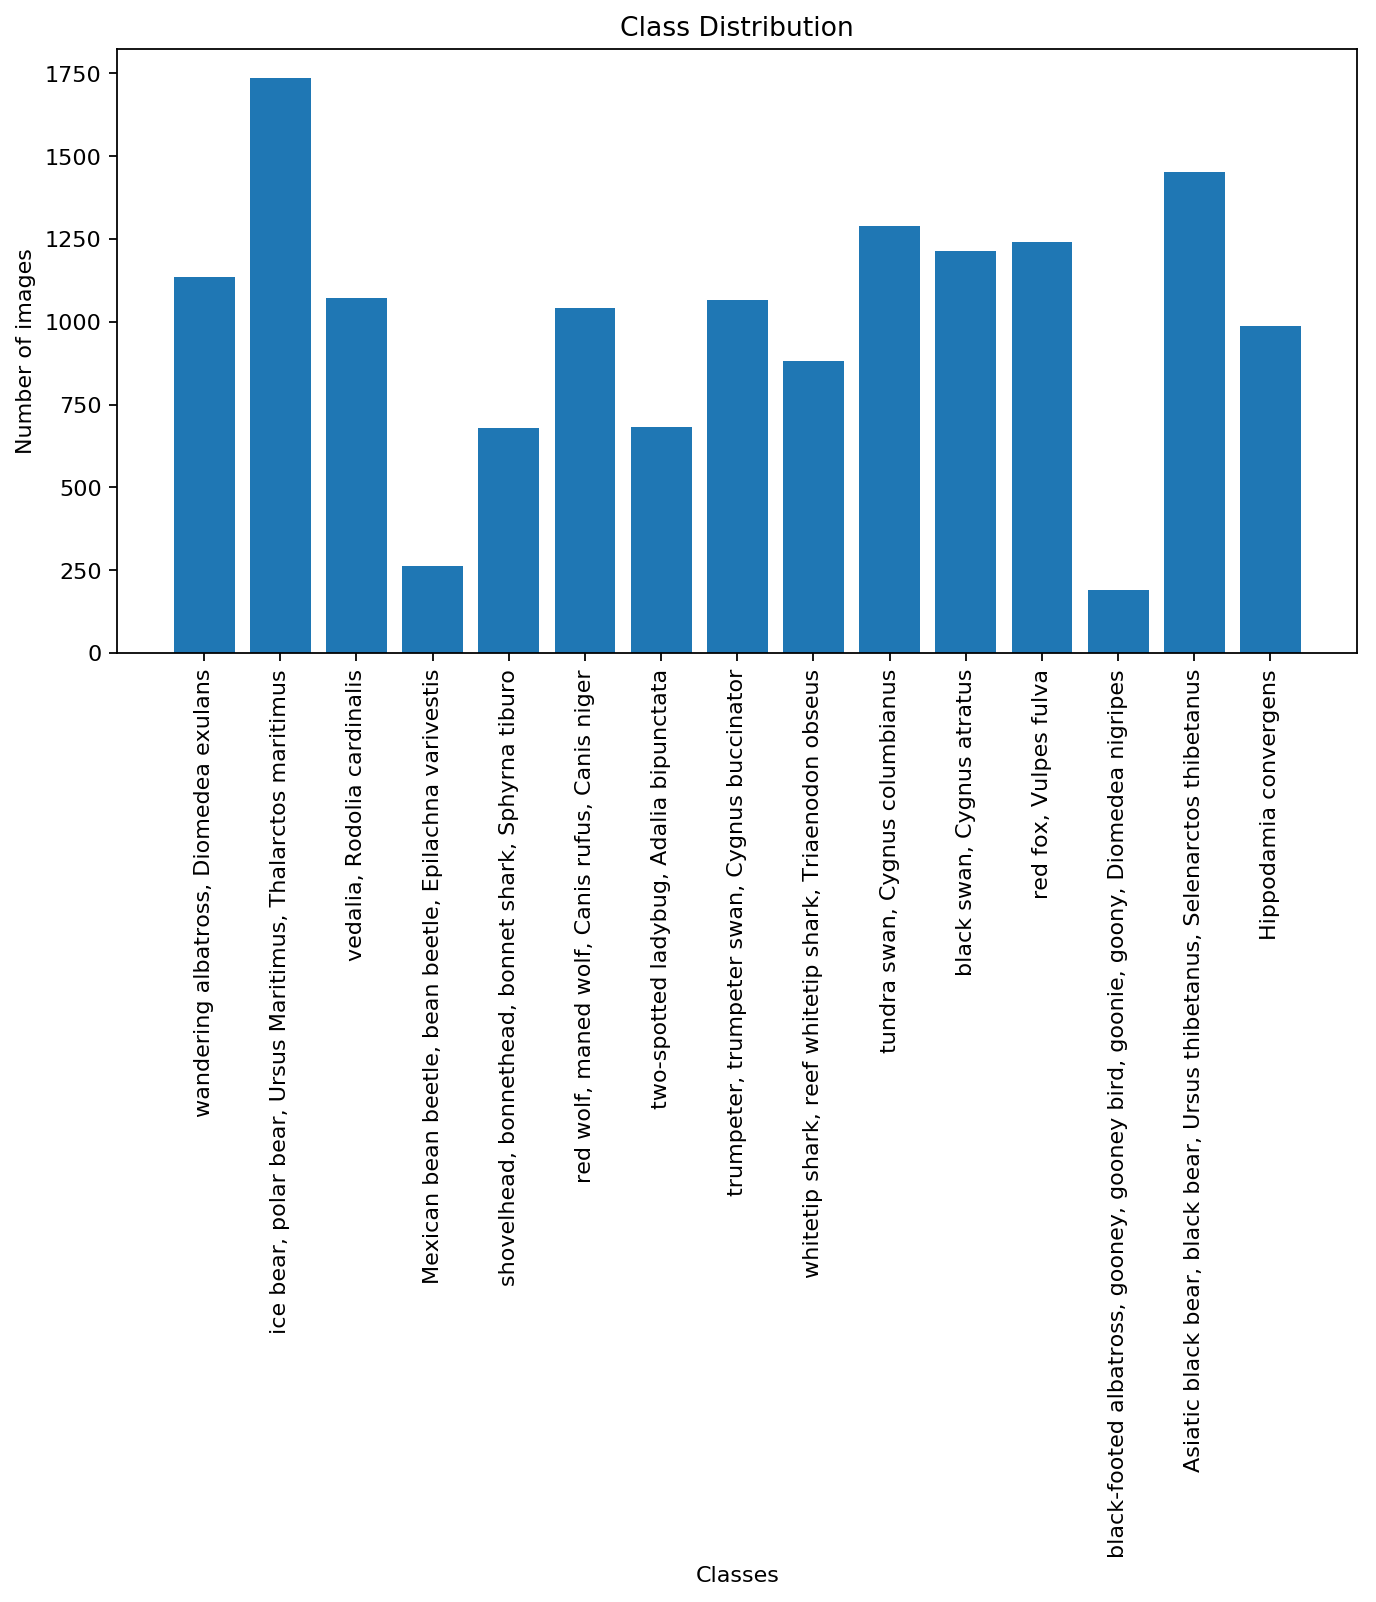

In [12]:
ImageProcessor.set_image_size(10, 5)
class_distribution = Analytics.extract_class_distribution(train)
classes = map(lambda x: wnid_to_lable[x], class_distribution.keys())

plt.bar(range(len(class_distribution)), class_distribution.values(), align='center')
plt.xticks(range(len(class_distribution)), classes, rotation='vertical')
plt.title('Class Distribution')
plt.ylabel('Number of images')
plt.xlabel('Classes')
plt.show()

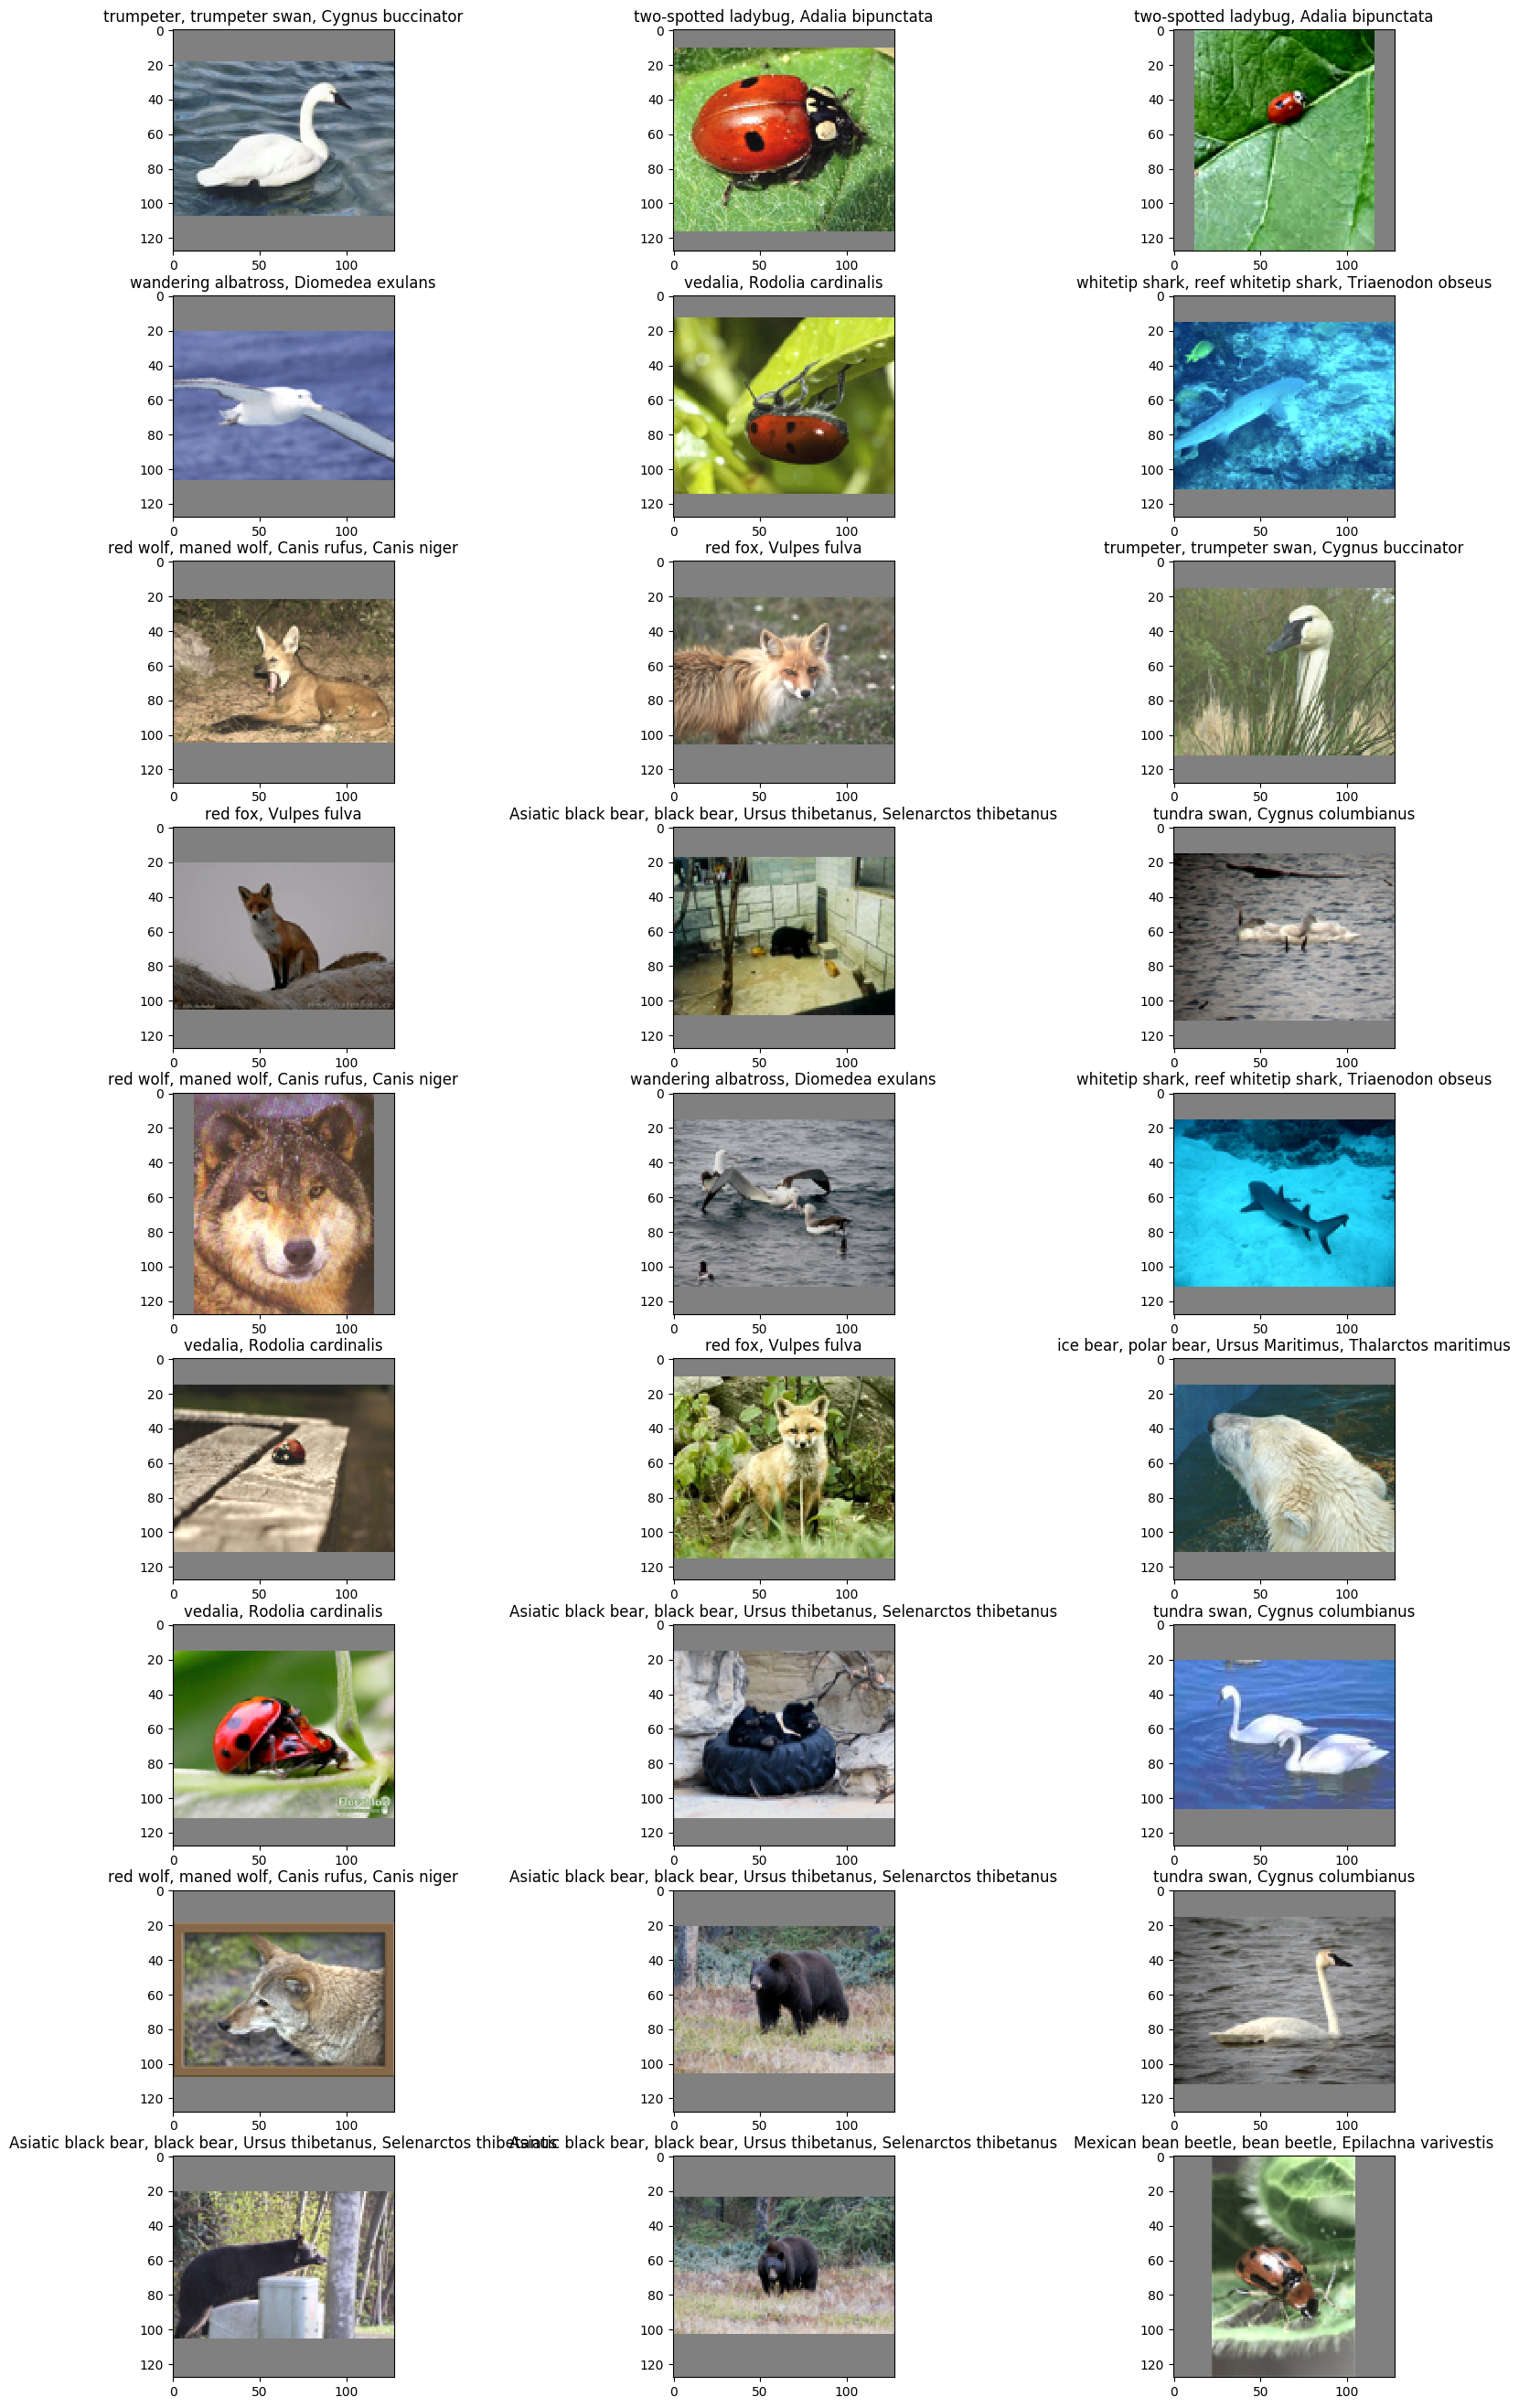

In [13]:
ImageProcessor.set_image_size(20, 34, 100)

for i in range(1, 28):
    plt.subplot(9, 3, i)
    
    random_index = np.random.randint(0, len(train))
    image_path = train[random_index]
    image = ImageProcessor.get_image(image_path)

    processed_image = ImageProcessor.get_processed_image(image, size=image_size)
    
    wnid = DatasetProcessor.extract_wnid(image_path)
    plt.title(wnid_to_lable[wnid])
    
    plt.imshow(processed_image)
    
    
plt.show()

## Data jittering

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [15]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

red wolf, maned wolf, Canis rufus, Canis niger


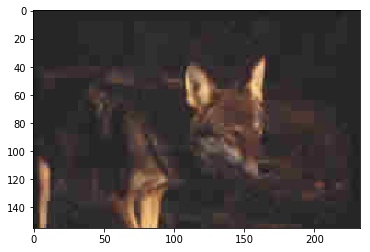

In [16]:
random_index = np.random.randint(0, len(train))
image_path = train[random_index]

wnid = DatasetProcessor.extract_wnid(image_path)
print(wnid_to_lable[wnid])

img = ImageProcessor.get_image(image_path)  # this is a PIL image

plt.imshow(img)
plt.show()

## Baseline convnet

In [ ]:
#import fileupload
#fileupload.nbinstall()

# Run in keras docker
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, BatchNormalization, Input

from keras_tqdm import TQDMNotebookCallback
from keras.models import model_from_json, Model, Sequential

from keras import backend as K
K.set_image_dim_ordering('tf')

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [ ]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('shallow_model.h5')  # always save your weights after training or during training

## Deeper model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        classes=classes
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        classes=classes
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('deeper_model.h5')  # always save your weights after training or during training

## Deeper model + batch norm + agressive jittering

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('batch_norm.h5')  # always save your weights after training or during training

## ResNet

In [17]:
from keras.applications import ResNet50, InceptionV3, Xception

from keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Sequential, Model, load_model
from keras_tqdm import TQDMNotebookCallback
from keras.optimizers import Adam, Adamax, RMSprop
from keras.activations import relu, elu, tanh, sigmoid
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import f1_score, recall_score, precision_score, log_loss, accuracy_score

from keras import backend as K
K.set_image_dim_ordering('tf')

In [18]:
IMG_DIM = 224
INPUT_TENSOR = Input(shape=(IMG_DIM, IMG_DIM, 3))

In [19]:
base_model = ResNet50(input_tensor=INPUT_TENSOR, include_top=False)

In [ ]:
#base_model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))

top_model.add(Dense(512))
top_model.add(BatchNormalization())
top_model.add(Activation(elu))
top_model.add(Dropout(0.3))

top_model.add(Dense(512))
top_model.add(BatchNormalization())
top_model.add(Activation(elu))

top_model.add(Dense(15, activation='softmax'))

In [ ]:
model = Model(input= base_model.input, output= top_model(base_model.output))

In [23]:
batch_size = 32
TRAIN_STEPS = math.ceil(TRAIN_SIZE / batch_size)
VALIDATION_STEPS = math.ceil(TEST_SIZE / batch_size)

print(TRAIN_STEPS, VALIDATION_STEPS)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(IMG_DIM, IMG_DIM),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(IMG_DIM, IMG_DIM),
        batch_size=batch_size,
        class_mode='categorical')

467 52
Found 14929 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [24]:
#model = load_model('FineTunedResNet.h5')

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [26]:
model.fit_generator(
        train_generator,
        steps_per_epoch=TRAIN_STEPS,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

# Inception v3
# 0.001
# 100% 5/5 [1:07:17<00:00, 808.72s/it]
# [loss: 0.920, acc: 0.662, val_loss: 0.609, val_acc: 0.763] 100% 234/234 [13:47<00:00, 31.12s/it]
# [loss: 0.722, acc: 0.718, val_loss: 0.526, val_acc: 0.787] 100% 234/234 [13:21<00:00, 27.04s/it]
# [loss: 0.679, acc: 0.736, val_loss: 0.476, val_acc: 0.790] 100% 234/234 [13:22<00:00, 27.15s/it]
# [loss: 0.651, acc: 0.743, val_loss: 0.489, val_acc: 0.787] 100% 234/234 [13:22<00:00, 27.20s/it]
# [loss: 0.634, acc: 0.751, val_loss: 0.481, val_acc: 0.793] 100% 234/234 [13:23<00:00, 27.19s/it]

# 0.0001
# [loss: 0.604, acc: 0.763, val_loss: 0.454, val_acc: 0.808] 100% 467/467 [14:48<00:00, 27.96s/it]
# [loss: 0.599, acc: 0.769, val_loss: 0.455, val_acc: 0.815] 100% 467/467 [14:34<00:00, 27.90s/it]
# [loss: 0.580, acc: 0.775, val_loss: 0.456, val_acc: 0.802] 100% 467/467 [14:38<00:00, 26.89s/it]
# [loss: 0.568, acc: 0.775, val_loss: 0.438, val_acc: 0.820] 100% 467/467 [14:33<00:00, 27.18s/it]
# [loss: 0.568, acc: 0.776, val_loss: 0.428, val_acc: 0.812] 100% 467/467 [14:35<00:00, 27.17s/it]

# 0.00001
# [loss: 0.558, acc: 0.782, val_loss: 0.438, val_acc: 0.817] 100% 467/467 [14:41<00:00, 28.33s/it]
# [loss: 0.556, acc: 0.784, val_loss: 0.439, val_acc: 0.817] 100% 467/467 [14:49<00:00, 27.29s/it]
# [loss: 0.547, acc: 0.785, val_loss: 0.411, val_acc: 0.825] 100% 467/467 [15:03<00:00, 28.53s/it]
# [loss: 0.554, acc: 0.782, val_loss: 0.433, val_acc: 0.817] 100% 467/467 [16:03<00:00, 28.12s/it]
# [loss: 0.554, acc: 0.786, val_loss: 0.424, val_acc: 0.824] 100% 467/467 [15:31<00:00, 27.48s/it]

# ResNet50, adam 0.001
# [loss: 0.844, acc: 0.690, val_loss: 2.858, val_acc: 0.246] 100% 467/467 [19:51<00:00, 42.98s/it]
# [loss: 0.653, acc: 0.746, val_loss: 0.733, val_acc: 0.709] 100% 467/467 [19:48<00:00, 42.66s/it]
# [loss: 0.589, acc: 0.768, val_loss: 0.564, val_acc: 0.772] 100% 467/467 [19:51<00:00, 42.12s/it]
# [loss: 0.571, acc: 0.777, val_loss: 0.501, val_acc: 0.793] 100% 467/467 [19:35<00:00, 42.21s/it]
# [loss: 0.549, acc: 0.783, val_loss: 0.481, val_acc: 0.800] 100% 467/467 [19:36<00:00, 42.19s/it]
# [loss: 0.528, acc: 0.789, val_loss: 0.466, val_acc: 0.809] 100% 467/467 [19:46<00:00, 42.72s/it]
# [loss: 0.514, acc: 0.797, val_loss: 0.449, val_acc: 0.810] 100% 467/467 [20:12<00:00, 42.76s/it] SAVED

# 0.0001
# [loss: 0.449, acc: 0.824, val_loss: 0.407, val_acc: 0.834] 100% 467/467 [19:34<00:00, 42.57s/it]
# [loss: 0.428, acc: 0.832, val_loss: 0.432, val_acc: 0.820] 100% 467/467 [19:34<00:00, 42.42s/it]
# [loss: 0.419, acc: 0.835, val_loss: 0.419, val_acc: 0.830] 100% 467/467 [19:34<00:00, 42.44s/it]

# Recall: 0.789338862215
# Precison: 0.796896179912
# F1: 0.791169742376
# Acc: 0.82534869618

In [29]:
#model.save('ResNet50_0_83_FINAL.h5')
#model = load_model('ResNet50.h5')

In [27]:
metric_validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(IMG_DIM, IMG_DIM),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=lables)

metric_validation_generator.reset()
y_pred = model.predict_generator(metric_validation_generator, VALIDATION_STEPS)
y_pred = DatasetProcessor.softmax_predictions_to_one_hot(y_pred)

print(y_pred.shape)

y_test = []
metric_validation_generator.reset()
for validation_touple in metric_validation_generator:
    X_test_batch, y_pred_batch = validation_touple
    y_test.extend(y_pred_batch)
    
    if metric_validation_generator.batch_index == 0:
        break
    
y_test = np.array(y_test)
print(y_test.shape)

Found 1649 images belonging to 15 classes.
(1649, 15)
(1649, 15)


In [28]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred, 'macro')

print('Recall:', recall)
print('Precison:', precision)
print('F1:', f1)
print('Acc:', acc)

# Recall: 0.804009705221
# Precison: 0.801081708895
# F1: 0.801006177479
# Acc: 0.830200121286

Recall: 0.804009705221
Precison: 0.801081708895
F1: 0.801006177479
Acc: 0.830200121286


ResNet50 validation and training performance


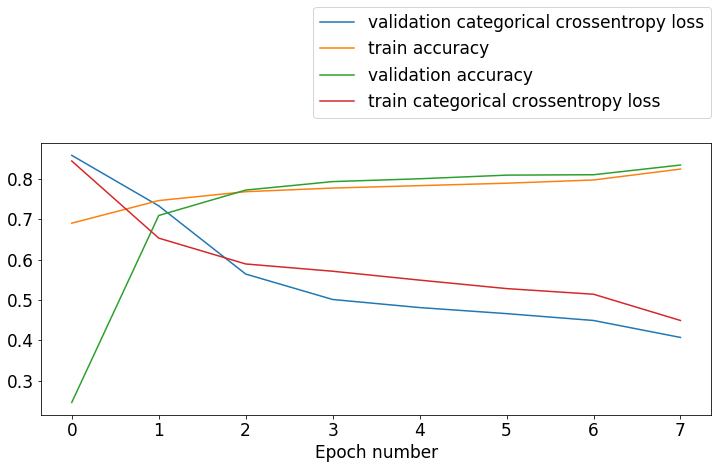

Inception v3 validation and training performance


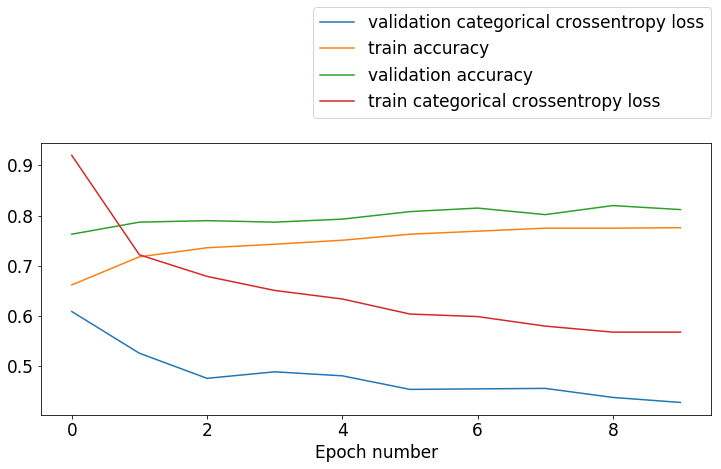

In [76]:
import matplotlib

inception_v3_training = {
    'train categorical crossentropy loss': [0.920, 0.722, 0.679, 0.651, 0.634, 0.604, 0.599, 0.580, 0.568, 0.568],
    'validation categorical crossentropy loss': [0.609, 0.526, 0.476, 0.489, 0.481, 0.454, 0.455, 0.456, 0.438, 0.428],
    'train accuracy': [0.662, 0.718, 0.736, 0.743, 0.751, 0.763, 0.769, 0.775, 0.775, 0.776],
    'validation accuracy': [0.763, 0.787, 0.790, 0.787, 0.793, 0.808, 0.815, 0.802, 0.820, 0.812],
}

res_net_training = {
    'train categorical crossentropy loss': [0.844, 0.653, 0.589, 0.571, 0.549, 0.528, 0.514, 0.449],
    'validation categorical crossentropy loss': [0.858, 0.733, 0.564, 0.501, 0.481, 0.466, 0.449, 0.407],
    'train accuracy': [0.690, 0.746, 0.768, 0.777, 0.783, 0.789, 0.797, 0.824],
    'validation accuracy': [0.246, 0.709, 0.772, 0.793, 0.800, 0.809, 0.810, 0.834],
}

models = {
    'Inception v3': inception_v3_training,
    'ResNet50': res_net_training
}
matplotlib.rcParams.update({'font.size': 17})

for model_name, graph_values in models.items():
    title = model_name + ' validation and training performance'
    #plt.title(title)
    print(title)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 5)
    
    for metric_name, metric_values in graph_values.items():
        plt.plot(range(len(metric_values)), metric_values, label=metric_name)
        plt.legend(bbox_to_anchor=(1, 1.5), loc=1, borderaxespad=0.)
        
    plt.xlabel('Epoch number')
    plt.show()

In [ ]:
class_num = [15, 14, 13, 12, 11, 10, 9, 8, 7]
acc = [0.835, 0.832, 0.866, 0.892, 0.884, 0.888, 0.875, 0.872,  0.871]

ImageProcessor.set_image_size(13, 5, 72)
plt.plot(class_num, acc)

plt.rcParams.update({'font.size': 14})

plt.title('Model accuracy with different class numbers')
plt.xlabel('Class number')
plt.ylabel('Accuracy')
plt.savefig('model_acc.png')
plt.show()

In [30]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization


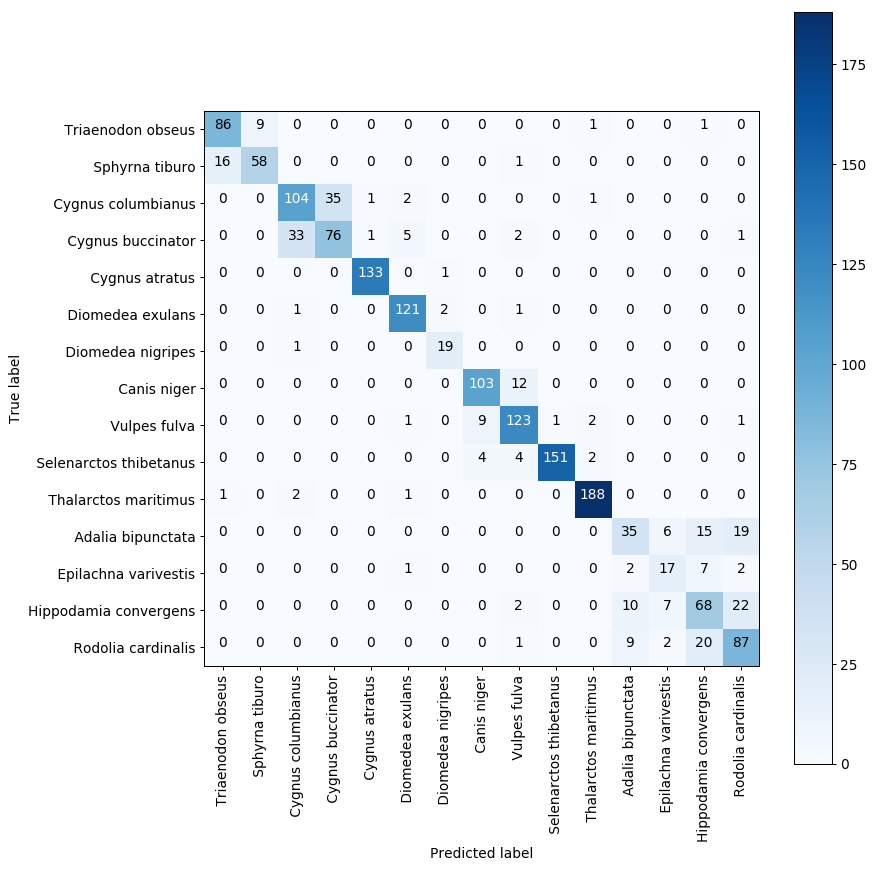

In [42]:
y_pred_categorical = DatasetProcessor.from_one_hot_to_categorical(y_pred)
y_test_categorical = DatasetProcessor.from_one_hot_to_categorical(y_test)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_categorical, y_pred_categorical)
np.set_printoptions(precision=2)

plt.figure()
ImageProcessor.set_image_size(10, 10, 90)

import matplotlib
matplotlib.rcParams.update({'font.size': 11})

classes = [wnid_to_lable[wnid] for wnid in wnids_train]

classes_latin = map(
    lambda x: x.split(',')[-1],
    classes
)

Analytics.plot_confusion_matrix(cnf_matrix, classes=list(classes_latin), title='')
plt.savefig('confusion_matrix.png')

In [44]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

## VGG16

In [ ]:
input_tensor = Input(shape=(150,150,3))
base_model = applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))

top_model.add(Dense(32))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))

top_model.add(Dense(64))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))

top_model.add(Dense(15, activation='softmax'))

In [ ]:
model = Model(input= base_model.input, output= top_model(base_model.output))

for layer in model.layers[:15]:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('vgg16.h5')  # always save your weights after training or during training

## Pretrained convnet

In [ ]:
from keras import applications

In [ ]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [ ]:
batch_size = 16

generator = datagen.flow_from_directory(
        '../input/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 14929)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

generator = datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 1649)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [ ]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 400 + [1] * 400)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')